In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/shstreuber/Data-Mining/master/data/West_Nile_Virus__WNV__Mosquito_Test_Results.csv")
df.head()

,SEASON YEAR,WEEK,TEST ID,BLOCK,TRAP,TRAP_TYPE,TEST DATE,NUMBER OF MOSQUITOES,RESULT,SPECIES,LATITUDE,LONGITUDE,LOCATION
0,2014,39,40542,100XX W OHARE AIRPORT,T902,GRAVID,09/25/2014 12:09:00 AM,8,negative,CULEX PIPIENS/RESTUANS,NaN,NaN,NaN
1,2016,37,44219,100XX W OHARE AIRPORT,T902,GRAVID,09/15/2016 12:09:00 AM,39,negative,CULEX PIPIENS/RESTUANS,NaN,NaN,NaN
2,2017,33,45351,100XX W OHARE AIRPORT,T905,GRAVID,08/17/2017 12:08:00 AM,50,positive,CULEX PIPIENS/RESTUANS,NaN,NaN,NaN
3,2017,33,45345,100XX W OHARE AIRPORT,T900,GRAVID,08/17/2017 12:08:00 AM,17,positive,CULEX PIPIENS/RESTUANS,NaN,NaN,NaN
4,2016,37,44169,4XX W 127TH,T135,GRAVID,09/15/2016 12:09:00 AM,12,negative,CULEX PIPIENS/RESTUANS,NaN,NaN,NaN


## 3. Transform one attribute from categorical or string to numeric

In [ ]:
df['TRAP'] = df['TRAP'].astype('category')
df['TRAP'] = df['TRAP'].cat.codes

## 4. Normalize or Standardize the this attribute

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [ ]:
#Normalize
x = df['TRAP'].values
min_max_scaler = preprocessing.MinMaxScaler()

df['TRAP'] = min_max_scaler.fit_transform(np.reshape(x,(-1,1)))

## 5 Transform a second attribute from numeric to 5 categories: xs -- s -- m -- l -- xl. Put these values into their OWN column.

In [ ]:
bins = np.linspace(df['NUMBER OF MOSQUITOES'].min(),df['NUMBER OF MOSQUITOES'].max(),6)

labels = ['xs','s','m','l','xl']

df['NUMBER OF MOSQUITOES'] = pd.cut(df['NUMBER OF MOSQUITOES'] , bins=bins, labels=labels, include_lowest=True)

In [ ]:
df['NUMBER OF MOSQUITOES'].value_counts()

xs    22212
s      3036
l      2573
m      1667
xl        1
Name: NUMBER OF MOSQUITOES, dtype: int64

## 6 In a third attribute, find all the missing values and substitute them with "null" 

In [ ]:
df.LATITUDE.replace(np.nan,'null',inplace=True)

In [ ]:
df['LATITUDE'].isnull().sum()

0

## 7 Perform a 5-number summary for another numerical attribute. 

In [ ]:
df['TEST ID'].describe()

count    29489.000000
mean     35155.917156
std       8630.314684
min      20000.000000
25%      27718.000000
50%      35150.000000
75%      42641.000000
max      50029.000000
Name: TEST ID, dtype: float64

## 8 Split the dataset into 80% training set and 20% test set with sampling.

In [ ]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

## 9 Split the dataset into 75% training set and 25% test set with crossvalidation

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2)

## 10 Pick the 3 most important attributes and make a correlation matrix 

In [ ]:
df[['SEASON YEAR','WEEK','TRAP']].corr()

,SEASON YEAR,WEEK,TRAP
SEASON YEAR,1.000000,0.005214,0.072615
WEEK,0.005214,1.000000,-0.010129
TRAP,0.072615,-0.010129,1.000000


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df['BLOCK'] = df['BLOCK'].astype('category')
df['BLOCK'] = df['BLOCK'].cat.codes

df['TRAP_TYPE'] = df['TRAP_TYPE'].astype('category')
df['TRAP_TYPE'] = df['TRAP_TYPE'].cat.codes

df['TEST DATE'] = df['TEST DATE'].astype('category')
df['TEST DATE'] = df['TEST DATE'].cat.codes

df['RESULT'] = df['RESULT'].astype('category')
df['RESULT'] = df['RESULT'].cat.codes

df['SPECIES'] = df['SPECIES'].astype('category')
df['SPECIES'] = df['SPECIES'].cat.codes

df['LATITUDE'] = df['LATITUDE'].astype('category')
df['LATITUDE'] = df['LATITUDE'].cat.codes

df['LOCATION'] = df['LOCATION'].astype('category')
df['LOCATION'] = df['LOCATION'].cat.codes

df.LONGITUDE.replace(np.nan,0,inplace=True)

In [ ]:
X = df.drop('NUMBER OF MOSQUITOES',axis=1)
y = df['NUMBER OF MOSQUITOES']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)


0.7956934554086131

## 12 Build a confusion matrix and a classification report

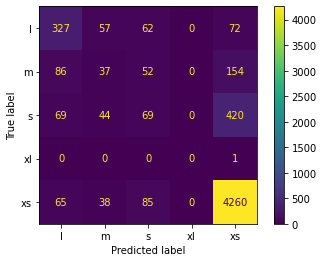

In [ ]:
# Next, the Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf, X_test, y_test)

In [ ]:
from sklearn.metrics import classification_report

print(metrics.classification_report(y_test, y_pred, labels=['xs','s','m','l','xl']))

              precision    recall  f1-score   support

          xs       0.87      0.96      0.91      4448
           s       0.26      0.11      0.16       602
           m       0.21      0.11      0.15       329
           l       0.60      0.63      0.61       518
          xl       0.00      0.00      0.00         1

    accuracy                           0.80      5898
   macro avg       0.39      0.36      0.37      5898
weighted avg       0.75      0.80      0.77      5898



## 13 Build a kMeans cluster analysis with an elbow plot

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# Elbow method

def elbow_plot(data, maxK=10, seed_centroids=None):
    """
        parameters:
        - data: pandas DataFrame (data to be fitted)
        - maxK (default = 10): integer (maximum number of clusters with which to run k-means)
        - seed_centroids (default = None ): float (initial value of centroids for k-means)
    """
    sse = {}
    for k in range(1, maxK):
        print("k: ", k)
        if seed_centroids is not None:
            seeds = seed_centroids.head(k)
            kmeans = KMeans(n_clusters=k, max_iter=500, n_init=100, random_state=0, init=np.reshape(seeds, (k,1))).fit(data)
            data["clusters"] = kmeans.labels_
        else:
            kmeans = KMeans(n_clusters=k, max_iter=300, n_init=100, random_state=0).fit(data)
            data["clusters"] = kmeans.labels_
        # Inertia: Sum of distances of samples to their closest cluster center
        sse[k] = kmeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.show()
    return

k:  1
k:  2
k:  3
k:  4
k:  5
k:  6
k:  7
k:  8
k:  9


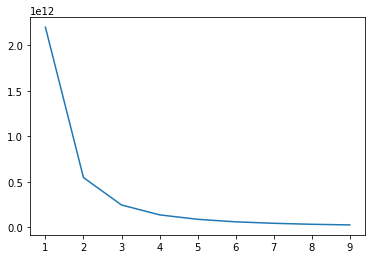

In [ ]:
elbow_plot(X,maxK=10)